In [1]:
import random
import sys
import time
from automation import automation,battle,random_battle,random_battle_env,general_battle_env

In [2]:
import jax
import jax.numpy as jnp
import haiku as hk

/opt/miniconda3/envs/myjax/lib/python3.9/site-packages/haiku/_src/data_structures.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))


In [3]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

attack: 1 damage

charge: next punch cause 1 more damage

shield: restore hp

In [4]:
def forward_pass(observation):
  # Implement forward pass here
  flat_obs = jnp.reshape(observation,-1)
  h = jax.nn.relu(hk.Linear(10)(flat_obs))
  p = hk.Linear(3)(h)
  v = hk.Linear(1)(h)
  return v, p

# Our forward pass will be deterministic, so we apply `hk.without_apply_rng`.
init_net, apply_net = hk.without_apply_rng(hk.transform(forward_pass))

@jax.jit
def softmax_policy(parameters, key, obs):
  """Sample action from a softmax policy."""
  ...
  v,p = apply_net(parameters,obs)
  action_prob = jax.nn.softmax(p)
  action = jax.random.choice(key, jnp.arange(len(action_prob)), p=action_prob)
  return action

def policy_gradient(parameters, obs_tm1, a_tm1, r_t, discount_t, obs_t):
  def apply_net_p(param,ob):
    action_prob = jax.nn.softmax(apply_net(param,ob)[1])
    return jnp.log(action_prob[a_tm1])
  vm1,pm1 = apply_net(parameters,obs_tm1)
  v,p = apply_net(parameters,obs_t)
  delta = r_t + discount_t * v - vm1
  grad_p = jax.grad(apply_net_p)(parameters,obs_tm1)
  grads = jax.tree_map(lambda x:delta*x,grad_p)
  return grads


def value_update(parameters, obs_tm1, a_tm1, r_t, discount_t, obs_t):
  def apply_net_v(param,ob):
    return apply_net(param,ob)[0][0]
  vm1,pm1 = apply_net(parameters,obs_tm1)
  v,p = apply_net(parameters,obs_t)
  delta = r_t + discount_t * v - vm1
  grad_v =  jax.grad(apply_net_v)(parameters,obs_tm1)
  td_update = jax.tree_map(lambda x:delta*x,grad_v)
  return td_update


@jax.jit
def compute_gradient(parameters, obs_tm1, a_tm1, r_t, discount_t, obs_t):
  pgrads = policy_gradient(parameters, obs_tm1, a_tm1, r_t, discount_t, obs_t)
  td_update = value_update(parameters, obs_tm1, a_tm1, r_t, discount_t, obs_t)
  return jax.tree_map(lambda pg, td: pg + td, pgrads, td_update)


@jax.jit
def epsilon_greedy_policy(parameters, key, observation):
  """Sample action from an epsilon-greedy policy."""
  v,p = apply_net(parameters,observation)
  action_prob = jax.nn.softmax(p)
  dice = jax.random.uniform(key)
  condx = dice < 0.9
  def random_action():
    return jax.random.choice(key, jnp.arange(len(action_prob)))
  def greedy_action():
    return jnp.argmax(action_prob)
  action = jax.lax.cond(condx,random_action,greedy_action)
  return action


##optimizer
def opt_init(parameters):
    mu = jax.tree_map(jnp.zeros_like, parameters)
    nu = jax.tree_map(jnp.zeros_like, parameters)
    opt_state = (mu, nu)
    return opt_state

def opt_update(grads, opt_state, alpha=0.003, b1=0.9, b2=0.999, eps=1e-4):
    mu, nu = opt_state
    mu = jax.tree_map(lambda g, m: (1 - b1) * g + b1 * m, grads, mu)  # update first moment
    nu = jax.tree_map(lambda g2, n: (1 - b2) * g2 + b2 * n, jax.tree_map(lambda g: g**2, grads), nu)  # update second moment
    updates = jax.tree_map(lambda m, n: alpha * m / (jnp.sqrt(n) + eps), mu, nu)  # compute updates
    opt_state = (mu, nu)  # update optimiser state
    return updates, opt_state

In [40]:
# Experiment configs.
train_episodes = 50000
discount_factor = .8#.4#.99

# Create environment.
env = random_battle_env()
# Build and initialize network.
rng = jax.random.PRNGKey(800)
rng, init_rng = jax.random.split(rng)
sample_input = env.get_status()#env.observation_spec().generate_value()
parameters = init_net(init_rng, sample_input)###inital status

# Initialize optimizer state.
opt_state = opt_init(parameters)

# Apply updates
def apply_updates(params, updates):
  return jax.tree_map(lambda p, u: p + u, params, updates)

# Jit.
opt_update = jax.jit(opt_update)
apply_updates = jax.jit(apply_updates)

print(f"Training agent for {train_episodes} episodes...")
all_episode_returns = []
all_results = []
first_action = []
n = 0
win = 0
total_return = 0
battle_length = []
battle_result = []
for _ in tqdm(range(train_episodes)):
  n+=1
  env = random_battle_env()
  episode_return = 0.
  #timestep = env.reset()
  obs_tm1 = env.get_status()#timestep.observation###initial value

  # Sample initial action.
  rng, policy_rng = jax.random.split(rng)
  a_tm1 = softmax_policy(parameters, policy_rng, obs_tm1)
  first_action.append(a_tm1)
  
  single_n = 0
  while not env.end:
    single_n+=1
    # Step environment.
    env.step(int(a_tm1))###update
    # Sample action from agent policy.
    rng, policy_rng = jax.random.split(rng)
    a_t = softmax_policy(parameters, policy_rng, env.get_status())
    # Update params.
    r_t = env.reward
    discount_t = discount_factor #* new_timestep.discount###discount
    dJ_dtheta = compute_gradient(
        parameters, obs_tm1, a_tm1, r_t, discount_t,
        env.get_status())
    updates, opt_state = opt_update(dJ_dtheta, opt_state)
    parameters = apply_updates(parameters, updates)

    # Within episode book-keeping.
    episode_return += env.reward###reward
    #timestep = new_timestep
    obs_tm1 = env.get_status()
    a_tm1 = a_t
  # Experiment results tracking.
  battle_length.append(single_n)
  battle_result.append(env.result)
  win+=env.result
  total_return+=episode_return
  all_results.append(win/n)
  all_episode_returns.append(total_return/n)

Training agent for 50000 episodes...


  0%|          | 0/50000 [00:00<?, ?it/s]

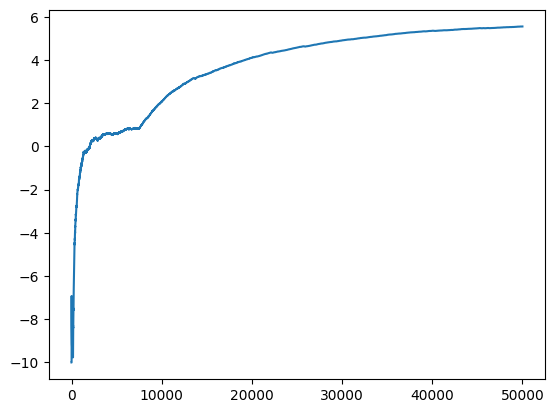

In [41]:
plt.plot(all_episode_returns)
plt.show()

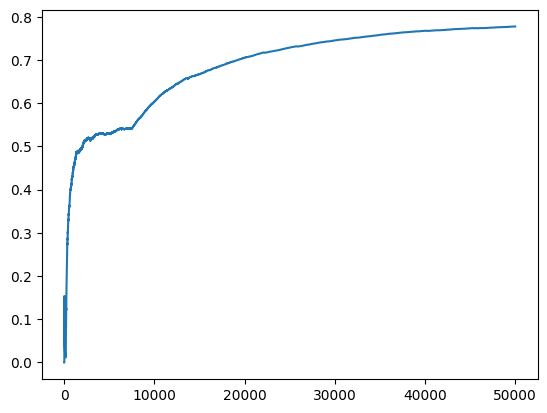

In [42]:
plt.plot(all_results)

In [35]:
all_results[-1]

0.52295

In [46]:
apply_net(parameters,np.array([5,1,1,5,1,1]))

(Array([9.0460205], dtype=float32),
 Array([-26.458055, -55.098423,  61.475815], dtype=float32))

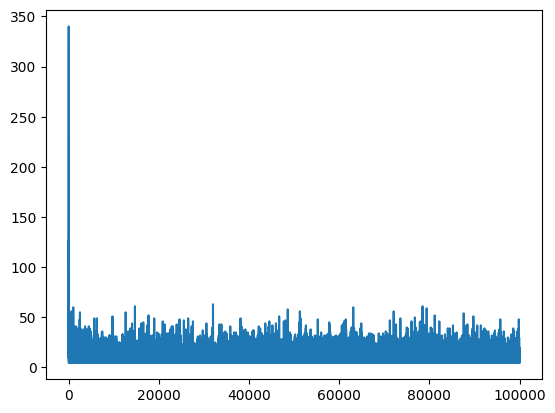

In [29]:
plt.plot(battle_length)

In [36]:
def pk_ai(parameters,n_round = 100):
    move = ['攻击','护盾','充能']
    rng = jax.random.PRNGKey(1000)
    rng, init_rng = jax.random.split(rng)
    env = general_battle_env(print_info=True)
    A = env.player
    B = env.enemy
    for i in range(n_round):
        time.sleep(0)
        if A.hp==0 and B.hp==0:
            print('TIE')
            break
        elif A.hp ==0:
            print('Win: B')
            break
        elif B.hp ==0:
            print('Win: A')
            break
        time.sleep(0.3)
        rng, policy_rng = jax.random.split(rng)
        a_t = softmax_policy(parameters, policy_rng, env.get_status())
        action = random.choice([0,1,2])
        print('palyer:',move[int(action)],'enemy:',move[int(a_t)])
        env.step(action_a=int(action),action_b=int(a_t))

In [41]:
pk_ai(parameters=parameters)

palyer: 攻击 enemy: 充能
charge: 2
HP of A:5, HP of B:4
palyer: 护盾 enemy: 充能
charge: 3
HP of A:5, HP of B:4
palyer: 攻击 enemy: 充能
charge: 4
HP of A:5, HP of B:3
palyer: 充能 enemy: 护盾
charge: 2
HP of A:5, HP of B:3
palyer: 护盾 enemy: 充能
charge: 5
HP of A:5, HP of B:3
palyer: 攻击 enemy: 护盾
HP of A:5, HP of B:5
palyer: 充能 enemy: 护盾
charge: 2
HP of A:5, HP of B:5
palyer: 充能 enemy: 护盾
charge: 3
SHIELD FAIL
HP of A:5, HP of B:5
palyer: 攻击 enemy: 护盾
HP of A:5, HP of B:5
palyer: 护盾 enemy: 护盾
HP of A:5, HP of B:5
palyer: 护盾 enemy: 充能
SHIELD FAIL
charge: 6
HP of A:5, HP of B:5
palyer: 攻击 enemy: 护盾
HP of A:5, HP of B:5
palyer: 充能 enemy: 护盾
charge: 2
SHIELD FAIL
HP of A:5, HP of B:5
palyer: 充能 enemy: 护盾
charge: 3
HP of A:5, HP of B:5
palyer: 护盾 enemy: 护盾
SHIELD FAIL
HP of A:5, HP of B:5
palyer: 攻击 enemy: 护盾
HP of A:5, HP of B:5
palyer: 攻击 enemy: 护盾
SHIELD FAIL
HP of A:5, HP of B:4
palyer: 护盾 enemy: 护盾
HP of A:5, HP of B:4
palyer: 护盾 enemy: 护盾
SHIELD FAIL
HP of A:5, HP of B:4
palyer: 护盾 enemy: 护盾
SHIELD FA

In [5]:
def softmax_policy_show(parameters, obs):
  """Sample action from a softmax policy."""
  ...
  v,p = apply_net(parameters,obs)
  action_prob = jax.nn.softmax(p)
  #action = jax.random.choice(key, jnp.arange(len(action_prob)), p=action_prob)
  return action_prob

In [ ]:
# Experiment configs.
train_episodes = 100
discount_factor = 1#.4#.99

# Create environment.
env = general_battle_env()
# Build and initialize network.
rng = jax.random.PRNGKey(171)
rng, init_rng = jax.random.split(rng)
sample_input = env.get_status()#env.observation_spec().generate_value()
parameters1 = init_net(init_rng, sample_input)###inital status
parameters2 = init_net(rng, sample_input)
# Initialize optimizer state.
opt_state1 = opt_init(parameters1)
opt_state2 = opt_init(parameters2)
# Apply updates
def apply_updates(params, updates):
  return jax.tree_map(lambda p, u: p + u, params, updates)

# Jit.
opt_update = jax.jit(opt_update)
apply_updates = jax.jit(apply_updates)

print(f"Training agent for {train_episodes} episodes...")
all_episode_returns = []
all_results = []
first_action = []
n = 0
win = 0
total_return = 0
battle_length = []
battle_result = []


for _ in tqdm(range(train_episodes)):
  n+=1
  env = general_battle_env()
  episode_return = 0.
  #timestep = env.reset()
  obs_tm1 = env.get_status()#timestep.observation###initial value
  obs_ene_tm1 = np.concatenate([obs_tm1[3:], obs_tm1[0:3]])
  # Sample initial action.
  rng, policy_rng = jax.random.split(rng)
  a_tm1 = softmax_policy(parameters1, policy_rng, obs_tm1)
  a_ene_tm1 = softmax_policy(parameters2, policy_rng, obs_ene_tm1)
  #first_action.append(a_tm1)
  
  single_n = 0
  while not env.end:
    single_n+=1
    # Step environment.
    # if single_n>10000:
    #   break
    env.step(int(a_tm1),int(a_ene_tm1))###update
    obs_t = env.get_status()#timestep.observation###initial value
    obs_ene_t = np.concatenate([obs_t[3:], obs_t[0:3]])
    # Sample action from agent policy.
    rng, policy_rng = jax.random.split(rng)
    a_t = softmax_policy(parameters1, policy_rng, obs_t)
    a_ene_t = softmax_policy(parameters2, policy_rng,obs_ene_t)

    # Update params1.
    r_t = env.reward
    discount_t = discount_factor #* new_timestep.discount###discount
    dJ_dtheta1 = compute_gradient(
        parameters1, obs_tm1, a_tm1, r_t, discount_t,
        obs_t)
    updates1, opt_state1 = opt_update(dJ_dtheta1, opt_state1,alpha=0.005)
    parameters1 = apply_updates(parameters1, updates1)

    # Update params2.
    dJ_dtheta2 = compute_gradient(
        parameters2, obs_ene_tm1, a_ene_tm1, -1*r_t, discount_t,
        obs_ene_t)
    updates2, opt_state2 = opt_update(dJ_dtheta2, opt_state2,alpha=0.005)
    parameters2 = apply_updates(parameters2, updates2)
    # Within episode book-keeping.
    episode_return += env.reward###reward
    #timestep = new_timestep
    obs_tm1 = obs_t
    obs_ene_tm1 = obs_ene_t
    a_tm1 = a_t
    a_ene_tm1 = a_ene_t
  # Experiment results tracking.
  battle_length.append(single_n)
  battle_result.append(env.result)
  win+=env.result
  total_return+=episode_return
  all_results.append(win/n)
  all_episode_returns.append(total_return/n)

Training agent for 100 episodes...


  0%|          | 0/100 [00:00<?, ?it/s]

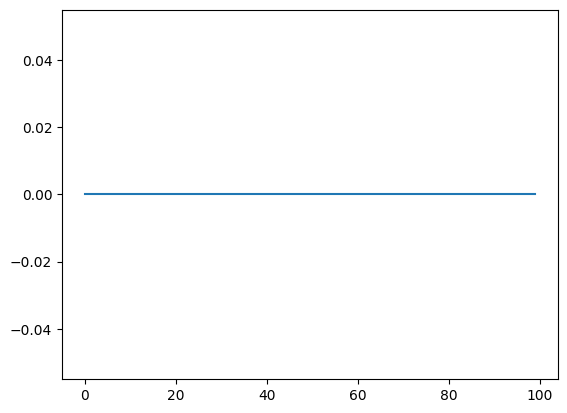

In [ ]:
plt.plot(all_results)
plt.show()

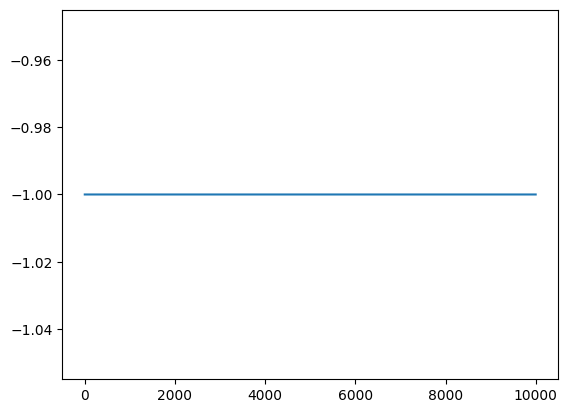

In [ ]:
plt.plot(all_episode_returns)

In [ ]:
pk_ai(parameters=parameters2)

palyer: 攻击 enemy: 攻击
HP of A:4, HP of B:4
palyer: 攻击 enemy: 攻击
HP of A:3, HP of B:3
palyer: 攻击 enemy: 攻击
HP of A:2, HP of B:2
palyer: 充能 enemy: 攻击
charge: 2
HP of A:1, HP of B:2
palyer: 护盾 enemy: 护盾
HP of A:1, HP of B:2
palyer: 攻击 enemy: 攻击
HP of A:0, HP of B:0
TIE


In [ ]:
softmax_policy_show(parameters1,np.array([5,1,1,5,1,1]))

/opt/miniconda3/envs/myjax/lib/python3.9/site-packages/haiku/_src/data_structures.py:143: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, treedef = jax.tree_flatten(tree)
/opt/miniconda3/envs/myjax/lib/python3.9/site-packages/haiku/_src/data_structures.py:144: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  return jax.tree_unflatten(treedef, leaves)


Array([2.1837493e-05, 1.7579328e-07, 9.9997795e-01], dtype=float32)

In [ ]:
apply_net(parameters1,np.array([5,1,1,5,1,1]))

(Array([10.566868], dtype=float32),
 Array([ -5.3902655, -10.21234  ,   5.3415947], dtype=float32))

In [ ]:
rng = jax.random.PRNGKey(42)
rng, init_rng = jax.random.split(rng)
sample_input = env.get_status()#env.observation_spec().generate_value()
parameters1 = init_net(init_rng, sample_input)###inital status
parameters2 = init_net(rng, sample_input)

In [ ]:
parameters1

{'linear': {'w': Array([[-0.7935275 ,  0.80601615,  0.19735399, -0.6366722 ,  0.44114345,
          -0.04707896, -0.4943798 , -0.5476676 , -0.6331858 ,  0.70860827],
         [ 0.43998352,  0.32449257, -0.05315362,  0.04882088,  0.37924567,
          -0.59017926, -0.46723738,  0.6625891 , -0.4014534 ,  0.40773937],
         [-0.08975432,  0.7300126 , -0.48044538, -0.36857706,  0.35927698,
           0.6203299 ,  0.36999503,  0.00247074,  0.6247445 , -0.00580645],
         [-0.31222975, -0.24359639, -0.74960005, -0.10061745, -0.17111067,
           0.7834183 , -0.28914347, -0.09202912, -0.64403015,  0.674368  ],
         [-0.28422782, -0.8046666 , -0.57493895,  0.17328234, -0.52355075,
           0.19650297,  0.31769583, -0.35716942,  0.29542887,  0.71062255],
         [ 0.29622406, -0.28418776, -0.5834744 ,  0.13450451, -0.48448268,
           0.21180566, -0.41243765, -0.266718  ,  0.33869985,  0.07994892]],      dtype=float32),
  'b': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dt

In [ ]:
parameters2

{'linear': {'w': Array([[ 0.21150798, -0.01283747,  0.5642013 ,  0.370608  ,  0.27134627,
          -0.08531143,  0.28313756, -0.44441816, -0.1102638 ,  0.36584237],
         [-0.11338871, -0.34913218,  0.37686306, -0.18959805,  0.49187633,
          -0.4564058 , -0.5326    ,  0.20780194,  0.2253618 ,  0.6935157 ],
         [ 0.20325628, -0.35181266,  0.2833298 ,  0.6546464 , -0.15085445,
          -0.41748413, -0.4444274 , -0.17384095, -0.1946807 ,  0.23759472],
         [ 0.5196442 ,  0.09309086,  0.57066125, -0.11848723,  0.42760137,
           0.4089856 ,  0.16094945, -0.24565384,  0.41067138,  0.20220461],
         [ 0.06220593,  0.1661346 ,  0.26641062,  0.15533479,  0.7308673 ,
          -0.37051767, -0.44130424, -0.38333848, -0.52060664,  0.2176072 ],
         [-0.52558255, -0.5270913 , -0.1285348 ,  0.33815104, -0.10091395,
          -0.78459024, -0.07855972,  0.1025846 ,  0.7401093 , -0.32956934]],      dtype=float32),
  'b': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dt